In [1]:
import os
BAR = 'Barcodes_1d'
ROOT = open('../root').read().strip()
print ROOT
img_path = os.path.join(ROOT, 'common')
print img_path
anno_path = os.path.join(ROOT, BAR, 'annotations.json')
print anno_path
voc_path = os.path.join(ROOT, 'VOC', 'JPEGImages')
print voc_path

/home/nik-kochetov/work
/home/nik-kochetov/work/common
/home/nik-kochetov/work/Barcodes_1d/annotations.json
/home/nik-kochetov/work/VOC/JPEGImages


In [2]:
import converter
from model import SSDModel
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
%matplotlib inline

Using TensorFlow backend.


In [3]:
model = SSDModel()

In [4]:
path = os.path.join(ROOT, 'gen3_models_1', 'model.24-02-2018.gen3.ssd.05.hdf5')
model.model.load_weights(path)

In [5]:
import json
with open(anno_path) as f:
    annos = json.loads(f.read())
print len(annos)
print annos[0]

8111
{u'name': u'0001.jpg', u'shape': [3585, 2661, 3], u'Rects': [[594, 1081, 326, 575], [568, 1054, 1131, 1382], [593, 1074, 718, 968], [572, 1057, 1566, 1817], [564, 1050, 1964, 2217], [567, 1048, 2437, 2691]], u'path': u'Barcodes_1d/UPC-E', u'id': u'0001', u'Types': [u'UPCE', u'UPCE', u'UPCE', u'UPCE', u'UPCE', u'UPCE']}


In [6]:
anno = annos[0]
curr_img_path = os.path.join(ROOT, anno['path'], anno['name'])
print curr_img_path

/home/nik-kochetov/work/Barcodes_1d/UPC-E/0001.jpg


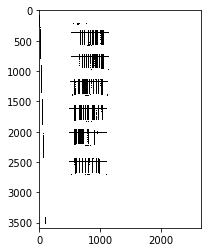

In [7]:
img = np.asarray(Image.open(curr_img_path))
imshow(img)

In [8]:
img.shape

(3585, 2661, 3)

In [9]:
factor = 4
shape = tuple(map(lambda x: x / factor, img.shape[:2]))
print shape

(896, 665)


In [10]:
img_2 = image.load_img(curr_img_path, target_size=shape)
img_2 = image.img_to_array(img_2)
img_2 = img_2.reshape([1] + list(img_2.shape))
img_2 = preprocess_input(img_2)
print img_2.shape

(1, 896, 665, 3)


In [11]:
tensor = model.model.predict(img_2) #img.reshape([1]  + list(img.shape)))

In [12]:
for val in tensor:
    print val.shape
    print val[np.nonzero(val)]

(1, 27, 19, 3)
[ -0.86372715   0.76470941  -0.06655782 ..., -20.23779488   4.44298506
  45.85625839]
(1, 27, 19, 3)
[  0.03925363  -0.11836647   0.22704741 ...,   3.69485807  -9.40776825
  14.92354012]
(1, 27, 19, 2)
[ -0.6553179    0.6791029    1.24575114 ..., -19.99058533  16.62624168
 -13.56785393]


In [13]:
print np.sort(tensor[0][np.nonzero(tensor[0])])

[-111.00476837  -94.97498322  -88.48622894 ...,  177.17224121  199.46881104
  206.03985596]


In [14]:
import generator
reload(generator)
from generator import Generator
ssd_generator = Generator(ROOT, model)

In [15]:
generator = ssd_generator.generate(annos, 64, True)

In [66]:
gen = next(generator)

next batch:
img: Barcodes_1d/Code 128C/0197.jpg
window:  Rect(71, 8, 1095, 1032)
tensors: [(3, 1, 0.0, 0.50390625, 1.0, 1.0, 0.49609375), (4, 1, 0.0, 0.00390625, 1.0, 0.5078125, 0.50390625), (4, 2, 0.0, 0.00390625, 0.7734375, 0.5078125, 0.389739990234375), (6, 1, 0.0, 0.3359375, 1.0, 0.84765625, 0.51171875), (6, 2, 0.0, 0.3359375, 1.0, 0.84765625, 0.51171875), (1, 0, 0.25, 0.48046875, 0.9375, 0.97265625, 0.33837890625), (2, 0, 0.25, 0.0, 0.9375, 0.47265625, 0.324951171875), (1, 1, 0.0, 0.48046875, 0.4375, 0.97265625, 0.21533203125)]


In [67]:
for key, value in gen[1].items():
    print key, value.shape
print gen[0]['input'].shape

tb_bbox (1, 15, 15, 4)
class (1, 15, 15, 2)
lr_bbox (1, 15, 15, 4)
(1, 512, 512, 3)


In [68]:
img = gen[0]['input']
print img.shape

(1, 512, 512, 3)


255.0 0.0


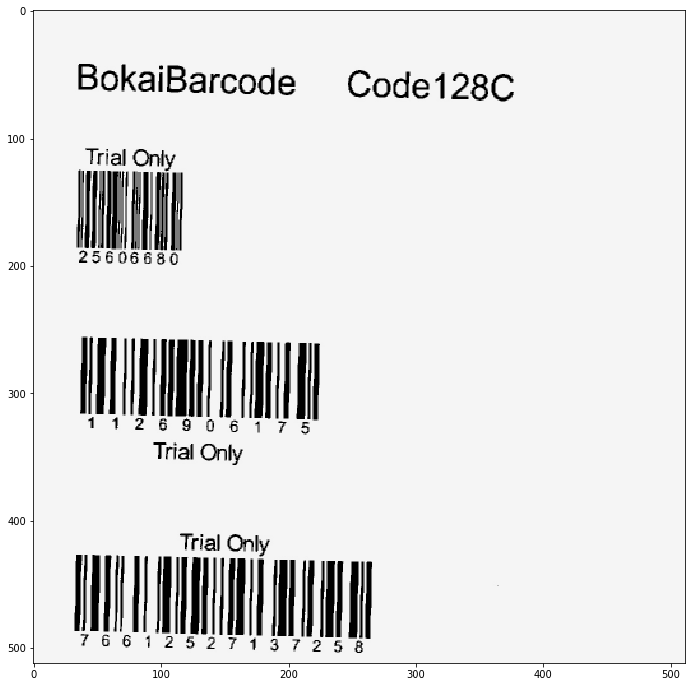

In [69]:
def show_img_from_gen(ax, img):
    def unprocess(y):
            x = np.copy(y)
            # Zero-decenter by mean pixel
            x[:, :, :, 0] += 103.939
            x[:, :, :, 1] += 116.779
            x[:, :, :, 2] += 123.68

            # 'BGR'->'RGB'
            x = x[:, :, :, ::-1]
            print np.max(x), np.min(x)
            return x / 265.0


    ax.imshow(np.reshape(unprocess(img)[0], img.shape[1:]))
    
    
fig, ax = plt.subplots(figsize=(12, 12))
show_img_from_gen(ax, img)

In [70]:
import converter
reload(converter)
ssd_converter = converter.Converter(model)

In [77]:
tensors = model.model.predict(np.zeros((1,256, 256, 3))) # model.model.predict(img)

In [78]:
for val in tensors:
    print val.shape
    print val[np.nonzero(val)][:10]

(1, 7, 7, 3)
[-0.86372715  0.76470941 -0.06655782 -1.03879094  1.04348946 -0.16383053
 -1.03879094  1.04348946 -0.16383053 -1.03879094]
(1, 7, 7, 3)
[ 0.03925363 -0.11836647  0.22704741 -0.19975336  0.03361505  0.27317509
 -0.19975336  0.03361505  0.27317509 -0.19975336]
(1, 7, 7, 2)
[-0.6553179   0.6791029   1.24575114 -1.18920708  1.24575114 -1.18920708
  1.24575114 -1.18920708  1.24575114 -1.18920708]


In [62]:
confs, rects = ssd_converter.restore_rects(tensors, top=20)
print confs
for rect in rects:
    print rect

15 15
8 8
(1, 15, 15, 2)
0.810434 0 0 0.120262 0.733108 0.326716 0.605789
Rect(0.2405247837305069, 0.65343272686004639, 1.4662153720855713, 1.2115781307220459)
Rect(15.393586158752441, 41.819694519042969, 93.837783813476562, 77.541000366210938)
0.0402686 0 1 0.087554 0.789977 0.258563 0.585088
Rect(1.1751079857349396, 0.51712548732757568, 2.5799543857574463, 1.1701756715774536)
Rect(75.206911087036133, 33.096031188964844, 165.11708068847656, 74.891242980957031)
0.0402686 0 2 0.087554 0.789977 0.258563 0.585088
Rect(2.1751079857349396, 0.51712548732757568, 3.5799543857574463, 1.1701756715774536)
Rect(139.20691108703613, 33.096031188964844, 229.11708068847656, 74.891242980957031)
0.0402686 0 3 0.087554 0.789977 0.258563 0.585088
Rect(3.1751079857349396, 0.51712548732757568, 4.5799543857574463, 1.1701756715774536)
Rect(203.20691108703613, 33.096031188964844, 293.11708068847656, 74.891242980957031)
0.0402686 0 4 0.087554 0.789977 0.258563 0.585088
Rect(4.1751079857349396, 0.517125487327575

0.000685006 6 4 0.0881289 0.775894 0.266561 0.674745
Rect(4.1762577444314957, 6.5331224203109741, 5.5517882108688354, 7.349489688873291)
Rect(267.28049564361572, 418.11983489990234, 355.31444549560547, 470.36734008789062)
0.000685006 6 5 0.0881289 0.775894 0.266561 0.674745
Rect(5.1762577444314957, 6.5331224203109741, 6.5517882108688354, 7.349489688873291)
Rect(331.28049564361572, 418.11983489990234, 419.31444549560547, 470.36734008789062)
0.000685006 6 6 0.0881289 0.775894 0.266561 0.674745
Rect(6.1762577444314957, 6.5331224203109741, 7.5517882108688354, 7.349489688873291)
Rect(395.28049564361572, 418.11983489990234, 483.31444549560547, 470.36734008789062)
0.000685006 6 7 0.0881289 0.775894 0.266561 0.674745
Rect(7.1762577444314957, 6.5331224203109741, 8.5517882108688354, 7.349489688873291)
Rect(459.28049564361572, 418.11983489990234, 547.31444549560547, 470.36734008789062)
0.000685006 6 8 0.0881289 0.775894 0.266561 0.674745
Rect(8.1762577444314957, 6.5331224203109741, 9.551788210868

0.000685006 12 1 0.0881289 0.775894 0.266561 0.674745
Rect(1.1762577444314957, 12.533122420310974, 2.5517882108688354, 13.349489688873291)
Rect(75.280495643615723, 802.11983489990234, 163.31444549560547, 854.36734008789062)
0.000685006 12 2 0.0881289 0.775894 0.266561 0.674745
Rect(2.1762577444314957, 12.533122420310974, 3.5517882108688354, 13.349489688873291)
Rect(139.28049564361572, 802.11983489990234, 227.31444549560547, 854.36734008789062)
0.000685006 12 3 0.0881289 0.775894 0.266561 0.674745
Rect(3.1762577444314957, 12.533122420310974, 4.5517882108688354, 13.349489688873291)
Rect(203.28049564361572, 802.11983489990234, 291.31444549560547, 854.36734008789062)
0.000685006 12 4 0.0881289 0.775894 0.266561 0.674745
Rect(4.1762577444314957, 12.533122420310974, 5.5517882108688354, 13.349489688873291)
Rect(267.28049564361572, 802.11983489990234, 355.31444549560547, 854.36734008789062)
0.000685006 12 5 0.0881289 0.775894 0.266561 0.674745
Rect(5.1762577444314957, 12.533122420310974, 6.551

255.0 0.0
Rect(15.393586158752441, 41.819694519042969, 93.837783813476562, 77.541000366210938)
Rect(17.652002334594727, 103.32733154296875, 103.00498962402344, 147.65042114257812)
Rect(17.652002334594727, 167.32733154296875, 103.00498962402344, 211.65042114257812)
Rect(17.652002334594727, 231.32733154296875, 103.00498962402344, 275.65042114257812)
Rect(17.652002334594727, 295.32733154296875, 103.00498962402344, 339.65042114257812)


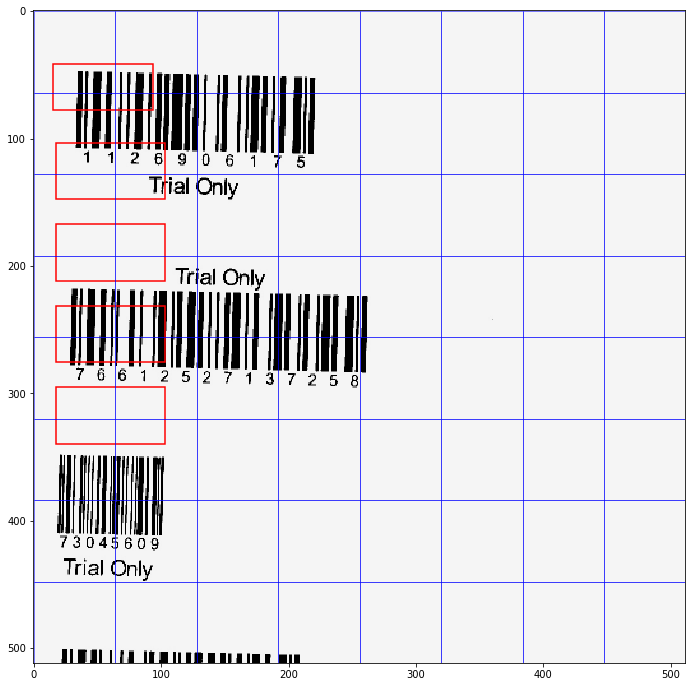

In [63]:
i = 0
# Create figure and axes
fig,ax = plt.subplots(1, figsize=(12, 12))

# Display the image
show_img_from_gen(ax, img)
shape = gen[0]['input'].shape[1:3]

#r = patches.Rectangle((50,50),100,100,linewidth=2,edgecolor='r',facecolor='none')
#ax.add_patch(r)

from rect import Rect
def clip_rect(rect, h, w):
    return Rect(max(0, rect.left), max(0, rect.top), min(w, rect.right), min(h, rect.bottom))

for rect in rects[:5]:
    # Create a Rectangle patch
    rr = clip_rect(rect, shape[0], shape[1])
    print rr
    #rr.dump()
    #rr.stretch(300, 300)
    #rr.dump()
    r = patches.Rectangle((rr.left,rr.top),rr.width(),rr.height(),linewidth=1.5,edgecolor='r' ,facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(r)
    
cnt = (gen[1]['class'].shape[1] + 1) / 2
edge = shape[0] / cnt
    
for i in range(cnt):
    for j in range(cnt):
    # Create a Rectangle patch
        rr = Rect(edge * i, edge * j, edge * (i + 1), edge * (j + 1))
        r = patches.Rectangle((rr.left,rr.top),rr.width(),rr.height(),linewidth=0.5,edgecolor='b',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(r)
    
for rect in []: #tr:
    # Create a Rectangle patch
    #rr = rect.copy()
    #rr.stretch(300, 300)
    r = patches.Rectangle((rr.left,rr.top),rr.width(),rr.height(),linewidth=2,edgecolor='g',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(r)

plt.show()

i += 1

In [20]:
reload(converter)
from converter import Converter
conv = Converter(os.path.join(ROOT, 'Barcodes', 'Rects'))

import predictor
reload(predictor)
from predictor import Predictor
ssd_predictor = Predictor(model, conv)

Exception: ssd model expected

In [21]:
#conv = Converter(os.path.join(ROOT, 'Barcodes', 'Rects'))
rects = ssd_predictor.predict(curr_img_path, top=3)

for rect in rects:
    print rect.conf
    rect.rect.dump()

NameError: name 'ssd_predictor' is not defined

l=6.6407028648,t=-117.915729243,r=179.845783622,b=401.699513027
None
l=-1.46740524331,t=-117.915729243,r=171.737675514,b=401.699513027
None
l=-9.57551335142,t=-109.807621135,r=163.629567405,b=409.807621135
None


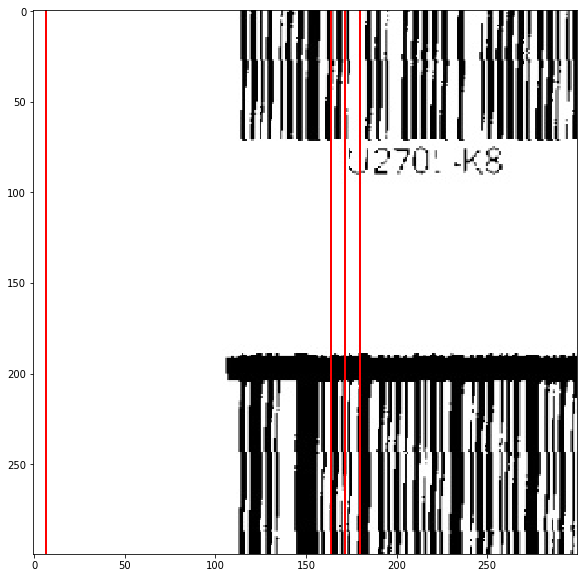

In [99]:
# Create figure and axes
fig,ax = plt.subplots(1, figsize=(12, 10))

# Display the image
ax.imshow(img)

#r = patches.Rectangle((50,50),100,100,linewidth=2,edgecolor='r',facecolor='none')
#ax.add_patch(r)


for rect in rects[:3]:
    # Create a Rectangle patch
    rr = rect.rect.copy()
    #rr.stretch(300, 300)
    print rr.dump()
    r = patches.Rectangle((rr.left,rr.top),rr.width(),rr.height(),linewidth=2,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(r)

plt.show()